# Phase 1: Raw Data Ingestion & Exploratory Diagnosis

Before applying any transformations or cleaning algorithms, we must first establish a baseline understanding of the raw dataset. This phase focuses on Data Profiling: assessing the structural integrity, completeness, and distributional behavior of our integrated data sources.

The dataset represents a merger between continuous Meteorological Records (Temperature, Wind, Humidity) and sporadic Wildfire Events (Fire Size, Location). Because these two distinct sources were integrated via a Left Join, we anticipate significant structural anomalies—specifically, large blocks of missing data on "non-fire" days and extreme outliers during fire events.

In [49]:
data = 'https://raw.githubusercontent.com/MajdBa7r/AQI/main/ontario_wildfire_weather_pm_2017_2024.csv'

In [113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
import matplotlib.ticker as ticker
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
data = pd.read_csv(data)

In [10]:
data.head()

,city,date,lat,lon,pm25,year,precipitation_sum (mm),rain_sum (mm),snowfall_sum (cm),relative_humidity_2m_mean (%),...,index_right,OGF_ID,FIRE_TYPE_CODE,FIRE_YEAR,FIRE_GENERAL_CAUSE_CODE,FIRE_WEATHER_INDEX,FIRE_RESPONSE_OBJ_CODE,FIRE_START_DATE,FIRE_OUT_DATE,FIRE_FINAL_SIZE
0,arnprior,2017-01-01,45.2001,-76.5278,2.090151,2017,2.8,0.0,1.96,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,atikokan,2017-01-01,51.2216,-90.2304,0.128585,2017,0.9,0.0,0.63,82.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bancroft,2017-01-01,45.5890,-78.3437,2.089787,2017,1.9,0.0,1.33,82.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,belleville,2017-01-01,44.4855,-77.4459,4.860390,2017,0.0,0.0,0.00,76.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bracebridge,2017-01-01,45.1669,-79.2325,6.356419,2017,1.8,0.2,1.12,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
print(f"Rows: {data.shape[0]}, Columns: {data.shape[1]}")

Rows: 139502, Columns: 34


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139502 entries, 0 to 139501
Data columns (total 34 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   city                               139502 non-null  object 
 1   date                               139502 non-null  object 
 2   lat                                139502 non-null  float64
 3   lon                                139502 non-null  float64
 4   pm25                               139502 non-null  float64
 5   year                               139502 non-null  int64  
 6   precipitation_sum (mm)             139502 non-null  float64
 7   rain_sum (mm)                      139502 non-null  float64
 8   snowfall_sum (cm)                  139502 non-null  float64
 9   relative_humidity_2m_mean (%)      139502 non-null  float64
 10  relative_humidity_2m_max (%)       139502 non-null  float64
 11  relative_humidity_2m_min (%)       1395

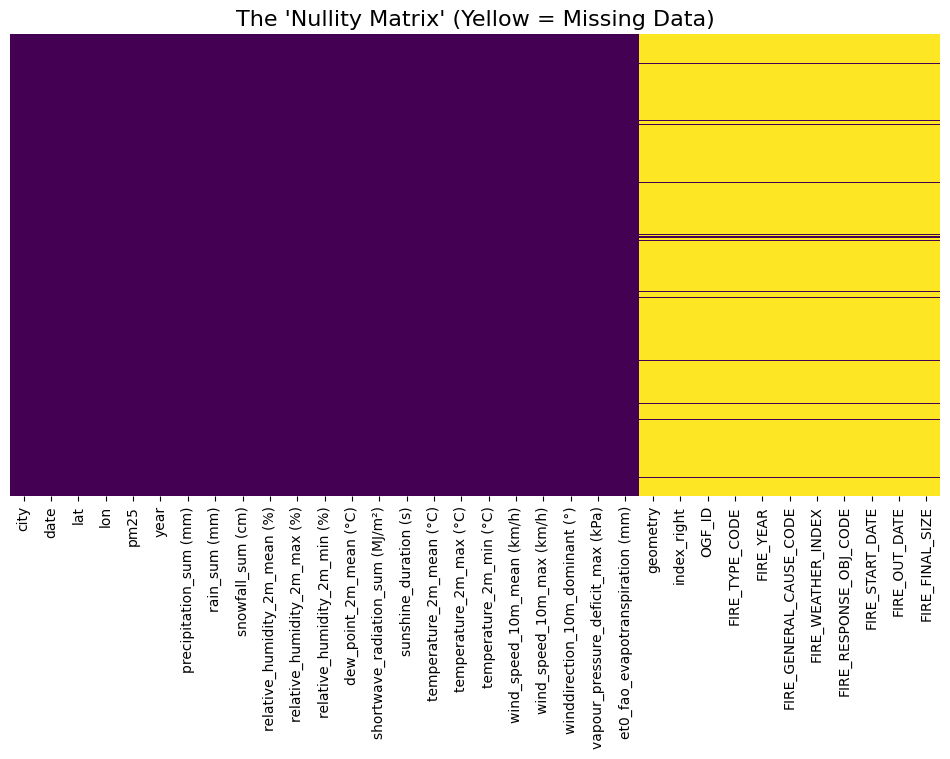

In [15]:
data.info()

plt.figure(figsize=(12, 6))
# cbar=False removes the legend (not needed here)
# yticklabels=False removes the row numbers (too messy)
sns.heatmap(data.isnull(), cbar=False, yticklabels=False, cmap='viridis')

plt.title("The 'Nullity Matrix' (Yellow = Missing Data)", fontsize=16)
plt.show()

The matrix reveals a distinct structural dichotomy in the dataset:

The Left Block (Meteorological Data): Columns such as temperature, wind, and precipitation are fully populated (purple). This confirms the existence of a high-fidelity, continuous time-series record for weather conditions.

The Right Block (Fire Data): Columns ranging from geometry to FIRE_FINAL_SIZE are predominantly null (yellow), punctuated only by sparse horizontal bands of data.

The structural split in the nullity matrix is the expected result of merging our sporadic "Fire Events" table onto the continuous "Daily Weather" baseline.

By utilizing a Left Join, we successfully preserved the complete timeline of weather conditions (indicated by the solid purple block on the left). Simultaneously, the fire data was integrated only where matches existed. The resulting yellow regions on the right are therefore not data errors, but rather Structurally Missing values that correctly represent days without fire incidents.

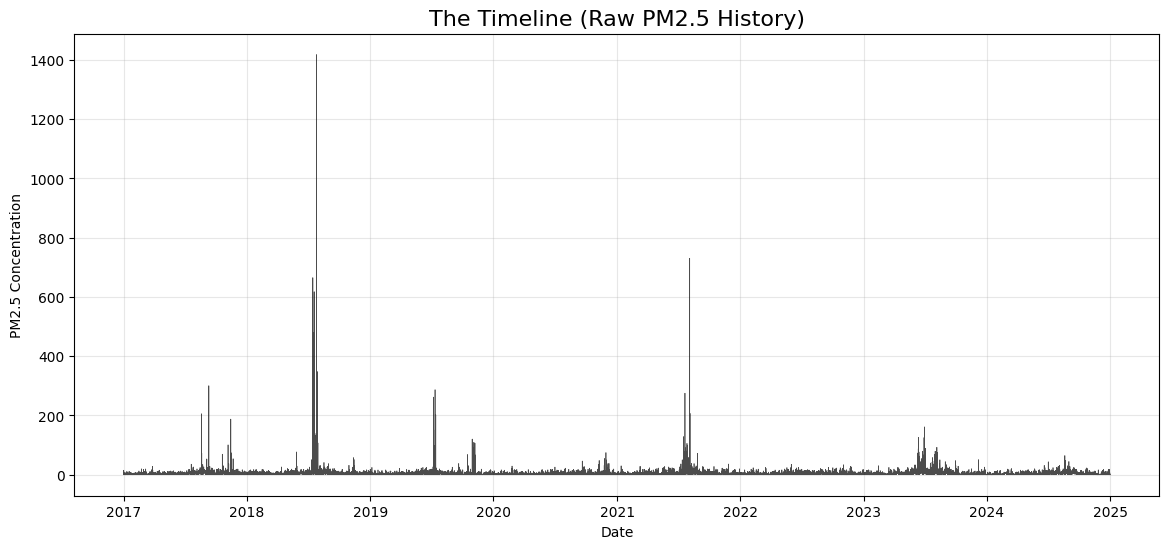

In [16]:
# Ensure Date is parsed
data['Date'] = pd.to_datetime(data['date'])

plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data['pm25'], color='black', linewidth=0.5, alpha=0.7)

plt.title("The Timeline (Raw PM2.5 History)", fontsize=16)
plt.ylabel("PM2.5 Concentration")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.show()

This plot reveals the "personality" of our target variable (PM2.5).

* The Baseline is Low: For the vast majority of the time (the bottom of the
chart), the PM2.5 levels are quite low (close to 0). This suggests that "normal" air quality in this location is generally good.

* The "Event" Nature is Extreme: The data is defined by massive, short-term explosions of pollution.

    * 2018/2019: There is a massive spike reaching over 1400.

    * 2021: Another significant spike reaching roughly 700.

These sharp, thin spikes perfectly match the behavior of wildfires. They are sporadic, intense events that cause air quality to skyrocket for a few days before returning to the baseline.

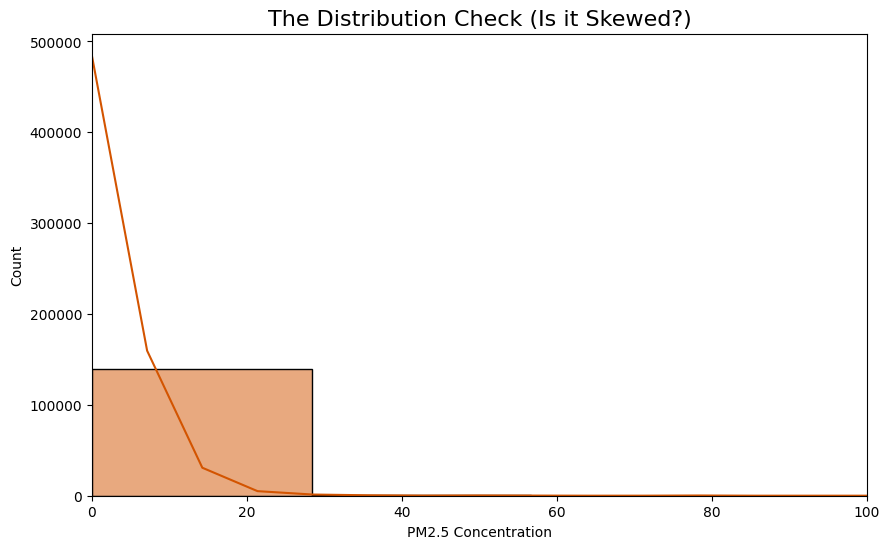

In [23]:
plt.figure(figsize=(10, 6))

# Histogram with a smooth curve (kde=True)
sns.histplot(data['pm25'], bins=50, kde=True, color='#D35400')

plt.title("The Distribution Check (Is it Skewed?)", fontsize=16)
plt.xlabel("PM2.5 Concentration")
plt.xlim(0, 100) # Zoom in to see the main body, ignoring extreme outliers
plt.show()

To understand the "normal" behavior, we zoomed the histogram to x < 100.

* Extreme Right Skew: The distribution is heavily right-skewed (positive skew).

* The "L" Shape: The curve drops precipitously, with the highest frequency of days falling between 0 and 10 PM2.5.

* This confirms that high pollution days are statistical rarities. The "mean" is likely dragged higher by the fire events, making the "median" a better representation of a typical day.




We are dealing with a highly imbalanced regression problem. Since the "Fire" signal is buried in a massive amount of "Clean Air" noise, standard models might struggle to predict the peaks. We may need to consider:

1 - Log-Transformation: To normalize the extreme skew of the target variable.

2 - Robust Scaling: To ensure the massive outliers (1400+) don't ruin the scaling for the other

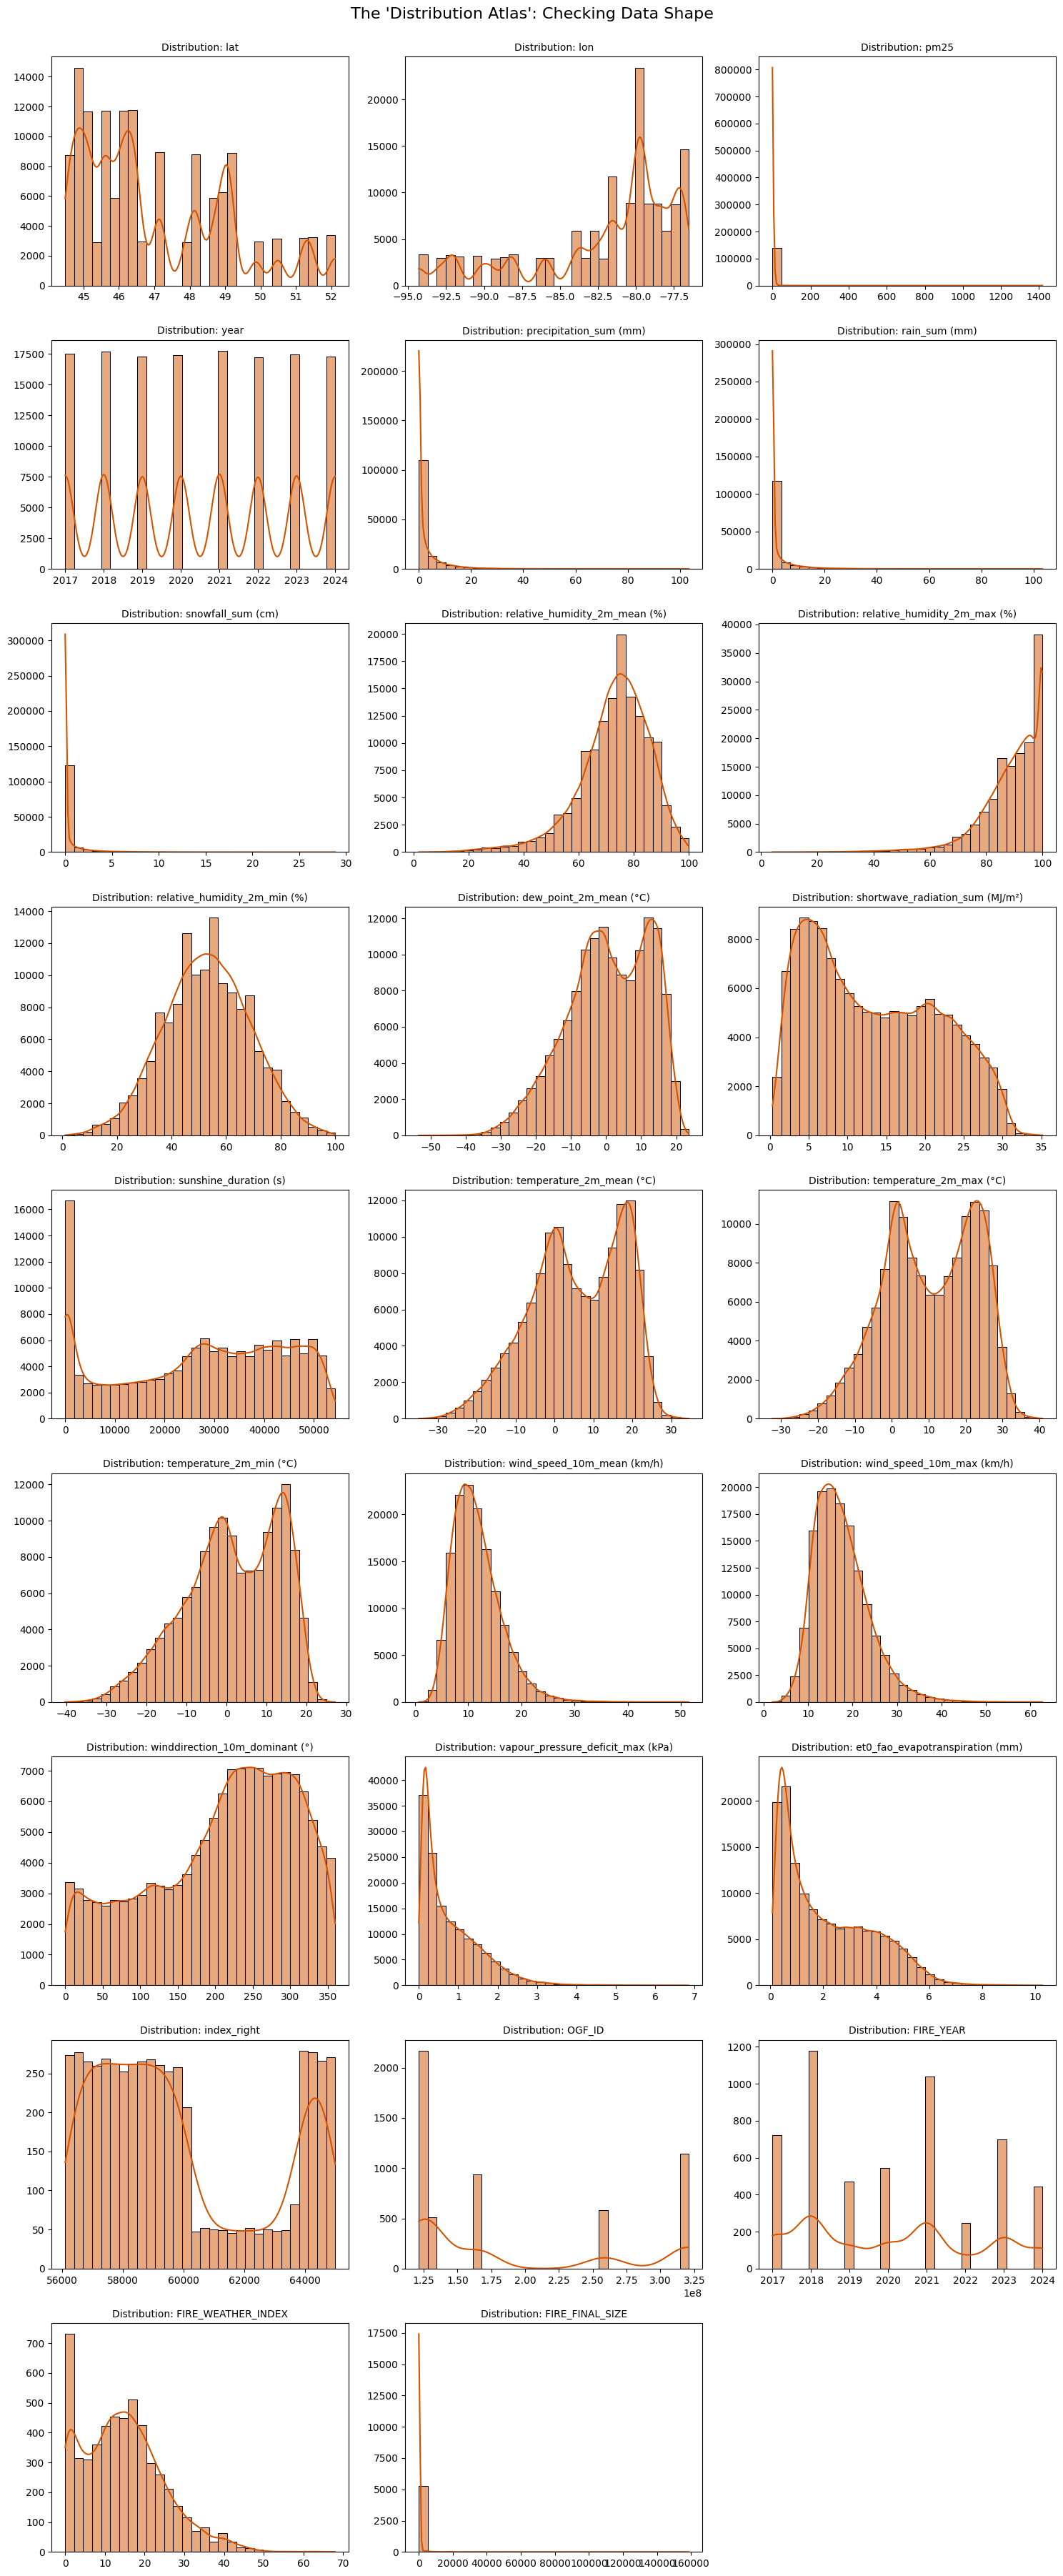

In [32]:
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
cols_to_plot = [c for c in numeric_cols if c not in ['Year', 'Month']]

n_cols = 3  # How many charts per row
n_rows = math.ceil(len(cols_to_plot) / n_cols)

plt.figure(figsize=(15, 4 * n_rows))

for i, col in enumerate(cols_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    # kde=True adds the smooth curve line
    sns.histplot(data[col], kde=True, color='#D35400', bins=30)
    plt.title(f"Distribution: {col}", fontsize=10)
    plt.xlabel("") # Remove x-label to keep it clean
    plt.ylabel("") # Remove y-label to keep it clean

plt.suptitle("The 'Distribution Atlas': Checking Data Shape", y=1, fontsize=16)
plt.tight_layout()
plt.show()

We have analyzed the distribution and behavior of both our target variable (pm25) and our feature set. The results paint a picture of a dataset driven by extreme events and strong seasonality.

The "Distribution Atlas" reveals distinct structural groups among the features:

Group A: The Seasonal Variables (Bimodal Distributions)

Variables: temperature_2m_mean, temperature_2m_max, temperature_2m_min, dew_point.

Observation: These plots show two distinct "humps" (bimodal).

Interpretation: This clearly captures the seasonal cycle (Winter vs. Summer). The model will easily be able to distinguish "Fire Season" (Summer hump) from "Low Risk Season" (Winter hump).



Group B: The Event Variables (Right-Skewed)

Variables: precipitation_sum, rain_sum, snowfall_sum, FIRE_FINAL_SIZE.

Observation: These look identical to our target variable: a massive bar at 0 and a long tail to the right.

Interpretation: Like PM2.5, rain and fire sizes are sporadic events.

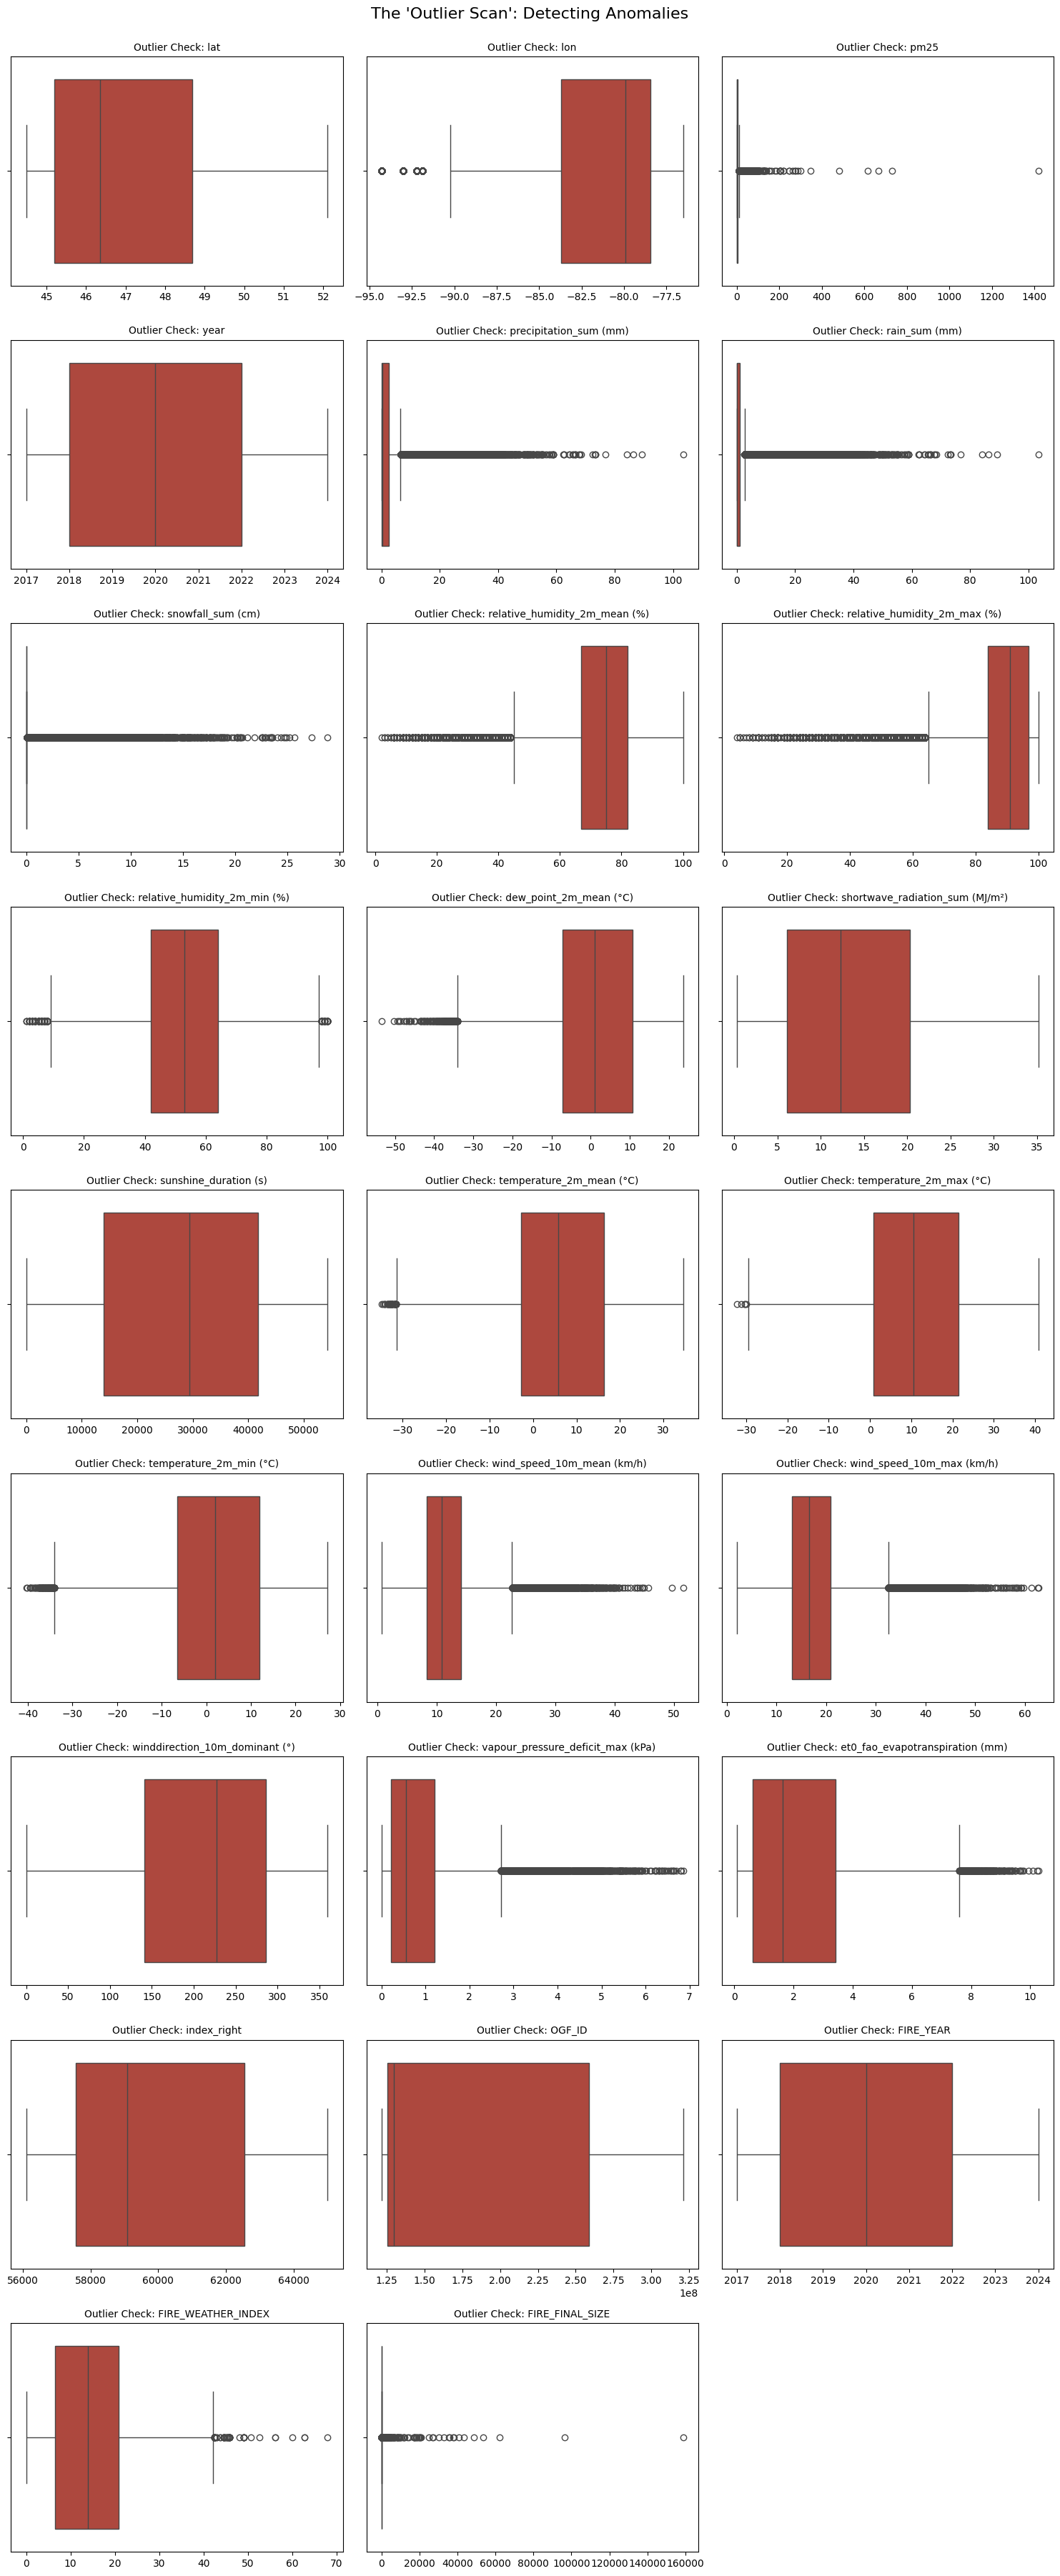

In [34]:
plt.figure(figsize=(15, 4 * n_rows))

for i, col in enumerate(cols_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=data[col], color='#C0392B')
    plt.title(f"Outlier Check: {col}", fontsize=10)
    plt.xlabel("") # Remove x-label to keep it clean

plt.suptitle("The 'Outlier Scan': Detecting Anomalies", y=1, fontsize=16)
plt.tight_layout()
plt.show()

The Outlier Scan (Boxplots) confirms that the "dots" on the far right of FIRE_FINAL_SIZE and pm25 are Signal, not Noise.

These are not data entry errors to be removed. They represent the actual wildfires we are trying to predict.

However, the scale difference is massive. To prevent these extreme values from dominating the gradients, we cannot use standard normalization (MinMax). We must use Robust Scaling, which scales data based on percentiles (IQR) and is immune to the distorting effects of extreme outliers.

The difference between the median (near 0) and the max (1400+) is enormous.

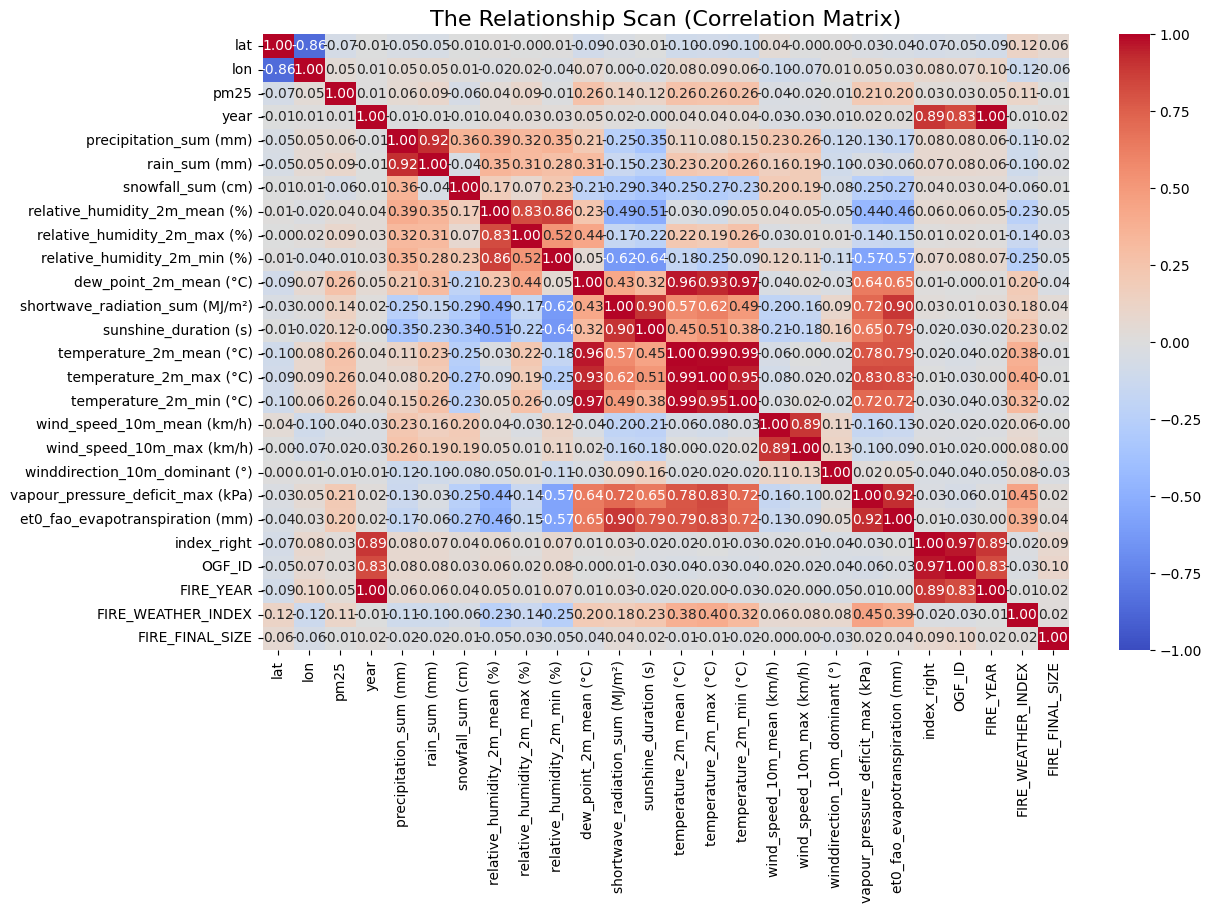

In [38]:
# Select only numeric columns for correlation
numeric_data = data.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(13, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

plt.title("The Relationship Scan (Correlation Matrix)", fontsize=16)
plt.show()

The correlation matrix reveals a critical insight: our target variable (pm25) shows extremely weak linear correlations with almost all predictors. Most coefficients hover between -0.05 and +0.10.



This is not a sign that the data is useless; rather, it is a mathematical artifact of the "Zero-Inflation" we identified in the Univariate analysis.

Both pm25 and FIRE_FINAL_SIZE are zero for the vast majority of days. Pearson correlation struggles to find a signal when 95% of the data points are overlapping zeros.

The relationship between a fire and smoke is likely threshold-based (non-linear), not a straight line. A correlation matrix only checks for straight lines.





Despite the "quiet" matrix, distinct patterns emerge when we look closely at the target row (pm25):

pm25 correlates more strongly with FIRE_WEATHER_INDEX (0.11) than with FIRE_FINAL_SIZE (0.02).

The potential for fire (weather conditions) is a more consistent predictor of air quality day-to-day than the raw reported size of a fire, likely because small fires are often unreported or have delayed smoke effects.

There is a slight positive correlation with temperature (~0.09) and a negative correlation with lat (-0.07), confirming that hotter, southern regions are slightly more prone to pollution spikes.

# Phase 2: Transition to Processed Data

Following our diagnosis of the raw data's structural issues (extreme skew, missing values, and scale disparity), the dataset has undergone a comprehensive preprocessing pipeline. Crucially, the following transformations have already been applied:

Imputation: Filling "non-fire" days to correct the Left Join gaps.

Log-Transformation: Applying np.log1p and yeo-johnson to tame the outliers.

Feature Engineering: Creation of time-lagged variables to capture the delayed effects of smoke.

We now proceed with this Engineered Dataset. Our immediate goal is to validate these transformations via a "Post-Cleaning EDA" before initializing our machine learning models.

In [76]:
data_after_cleaning = 'https://github.com/LamaEmran/Data/raw/main/X_train_with_y.csv'

In [77]:
new_data = pd.read_csv(data_after_cleaning)

In [78]:
new_data.head()

,city,FIRE_WEATHER_INDEX,FIRE_TYPE_CODE,FIRE_GENERAL_CAUSE_CODE,FIRE_RESPONSE_OBJ_CODE,year,precipitation_sum (mm),rain_sum (mm),snowfall_sum (cm),relative_humidity_2m_mean (%),...,fire_weather_risk,temp_range,inversion_risk,weather_cluster,distance_to_cluster_0,distance_to_cluster_1,distance_to_cluster_2,distance_to_cluster_3,date,PM2.5
0,-0.958333,0.0,-1.0,0.0,0.5,-1.0,0.715683,0.000000,1.269443,0.375,...,-0.706393,-0.600000,0.000000,1.0,-0.093150,-0.551029,0.314351,-1.224166,2017-01-01,1.128220
1,-0.916667,0.0,-1.0,0.0,0.5,-1.0,0.333682,0.000000,1.269443,0.500,...,-0.827332,-0.818182,2.685944,1.0,0.469552,-0.687842,0.646409,-1.158907,2017-01-01,0.120965
2,-0.875000,0.0,-1.0,0.0,0.5,-1.0,0.593969,0.000000,1.269443,0.500,...,-0.614719,-0.290909,0.000000,1.0,-0.001861,-0.518392,0.435891,-1.469979,2017-01-01,1.128102
3,-0.833333,0.0,-1.0,0.0,0.5,-1.0,-0.306375,0.000000,0.000000,0.125,...,-0.027544,0.036364,0.000000,-1.0,0.108214,-1.046667,0.078816,-0.477006,2017-01-01,1.768216
4,-0.791667,0.0,-1.0,0.0,0.5,-1.0,0.575905,0.424319,1.269443,0.625,...,-0.530605,-0.309091,0.000000,1.0,-0.215183,-0.410675,0.412197,-1.410711,2017-01-01,1.995573


In [79]:
print(f"Rows: {new_data.shape[0]}, Columns: {new_data.shape[1]}")

Rows: 109868, Columns: 34


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109868 entries, 0 to 109867
Data columns (total 34 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   city                               109868 non-null  float64
 1   FIRE_WEATHER_INDEX                 109868 non-null  float64
 2   FIRE_TYPE_CODE                     109868 non-null  float64
 3   FIRE_GENERAL_CAUSE_CODE            109868 non-null  float64
 4   FIRE_RESPONSE_OBJ_CODE             109868 non-null  float64
 5   year                               109868 non-null  float64
 6   precipitation_sum (mm)             109868 non-null  float64
 7   rain_sum (mm)                      109868 non-null  float64
 8   snowfall_sum (cm)                  109868 non-null  float64
 9   relative_humidity_2m_mean (%)      109868 non-null  float64
 10  relative_humidity_2m_max (%)       109868 non-null  float64
 11  relative_humidity_2m_min (%)       1098

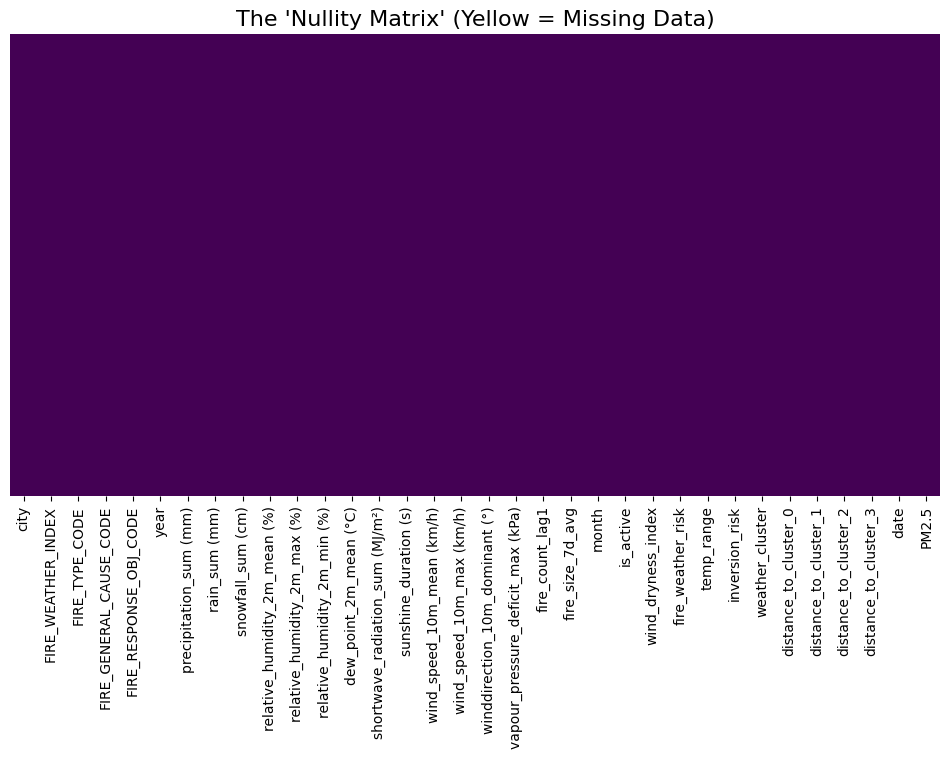

In [80]:
new_data.info()

plt.figure(figsize=(12, 6))
# cbar=False removes the legend (not needed here)
# yticklabels=False removes the row numbers (too messy)
sns.heatmap(new_data.isnull(), cbar=False, yticklabels=False, cmap='viridis')

plt.title("The 'Nullity Matrix' (Yellow = Missing Data)", fontsize=16)
plt.show()

Following the integration of the preprocessed dataset, we generated a final "Nullity Matrix" to verify structural integrity.

Visual Confirmation: The matrix is entirely dark purple, indicating that there are zero missing values remaining in the dataframe.

Validation of Imputation: The large yellow blocks observed in Phase 1 (representing "non-fire" days) have been successfully imputed. Columns such as FIRE_FINAL_SIZE and FIRE_WEATHER_INDEX are now fully populated, confirming that days without fire events have been correctly encoded.

New Features: We also observe the presence of engineered features (e.g., fire_size_lag1, distance_to_cluster_0) which are also fully populated.

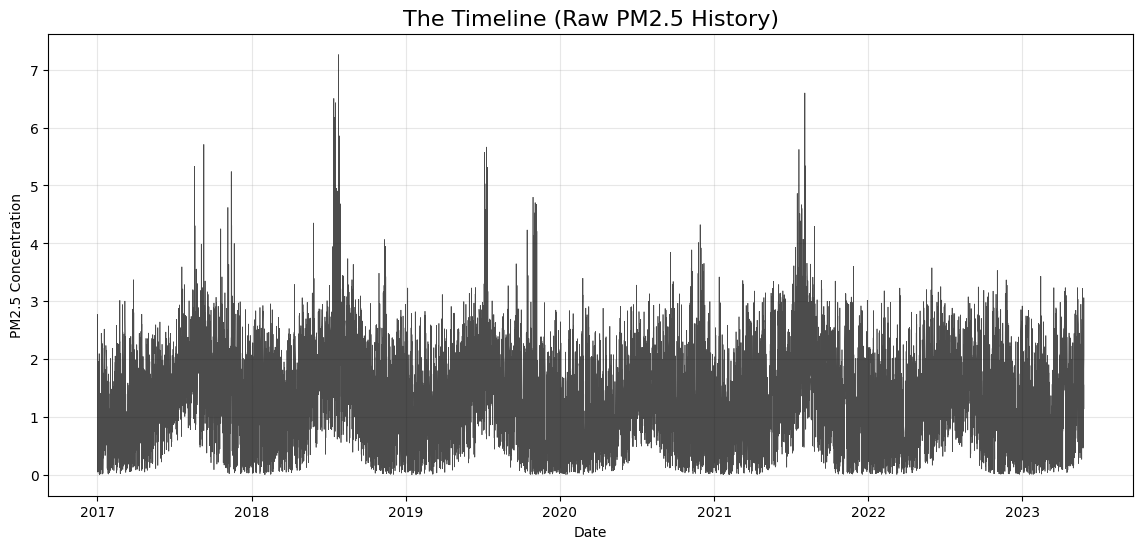

In [82]:
# Ensure Date is parsed
new_data['Date'] = pd.to_datetime(new_data['date'])

plt.figure(figsize=(14, 6))
plt.plot(new_data['Date'], new_data['PM2.5'], color='black', linewidth=0.5, alpha=0.7)

plt.title("The Timeline (Raw PM2.5 History)", fontsize=16)
plt.ylabel("PM2.5 Concentration")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.show()

Cyclical Seasonality: The data exhibits a clear, rhythmic annual pattern, indicating that PM2.5 concentrations are heavily influenced by seasonal factors.

High Volatility: The plot is characterized by "jagged" high-frequency noise, reflecting rapid day-to-day or hour-to-hour fluctuations in air quality rather than a smooth trend.

Distinct Outliers: There are sharp vertical spikes representing extreme events—likely wildfire smoke—with the most significant peaks occurring in late 2018 and mid-2021.

Scale Implications: The Y-axis ranges only from 0 to roughly 7.5. This relatively low maximum suggests the data may be log-transformed or normalized, as raw PM2.5 concentrations during wildfire events typically reach significantly higher numerical values.

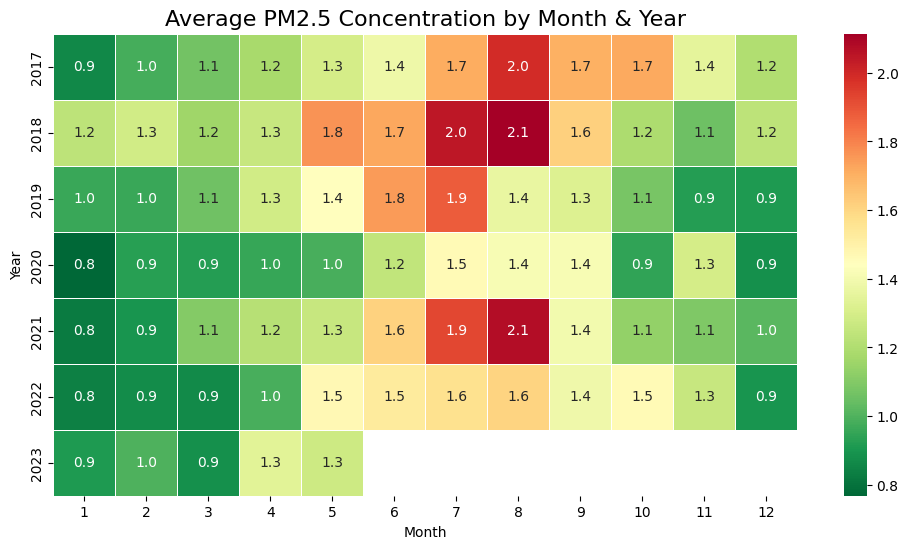

In [91]:
date_col = 'Date' if 'Date' in new_data.columns else 'date'
new_data[date_col] = pd.to_datetime(new_data[date_col])

new_data['Year'] = new_data[date_col].dt.year
new_data['Month'] = new_data[date_col].dt.month


pivot_table = new_data.pivot_table(values='PM2.5', index='Year', columns='Month', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='RdYlGn_r', annot=True, fmt=".1f", linewidths=.5)

plt.title("Average PM2.5 Concentration by Month & Year", fontsize=16)
plt.ylabel("Year")
plt.xlabel("Month")
plt.show()

The heatmap provides a clear visual summary of how air quality fluctuates over time, revealing distinct seasonal patterns and year-over-year variability.

There is a definitive "danger zone" during the summer months. The columns for July (7) and August (8) consistently show darker orange and red hues, indicating peak PM2.5 concentrations. This aligns perfectly with the typical Canadian wildfire season, confirming that time of year is a critical predictor for air quality.

Two specific years stand out as having the most intense pollution events:

2018: This appears to be a particularly bad year with a prolonged season. Elevated levels started as early as May (1.8) and sustained high values through August (2.1).

2021: This year shows a sharp, intense peak in late summer, hitting a maximum average of 2.1 in August.

The months of January through April and November through December generally remain green, with values hovering between 0.8 and 1.2. This represents the region's "baseline" air quality in the absence of major wildfire smoke, providing a control level against which the summer spikes can be measured.

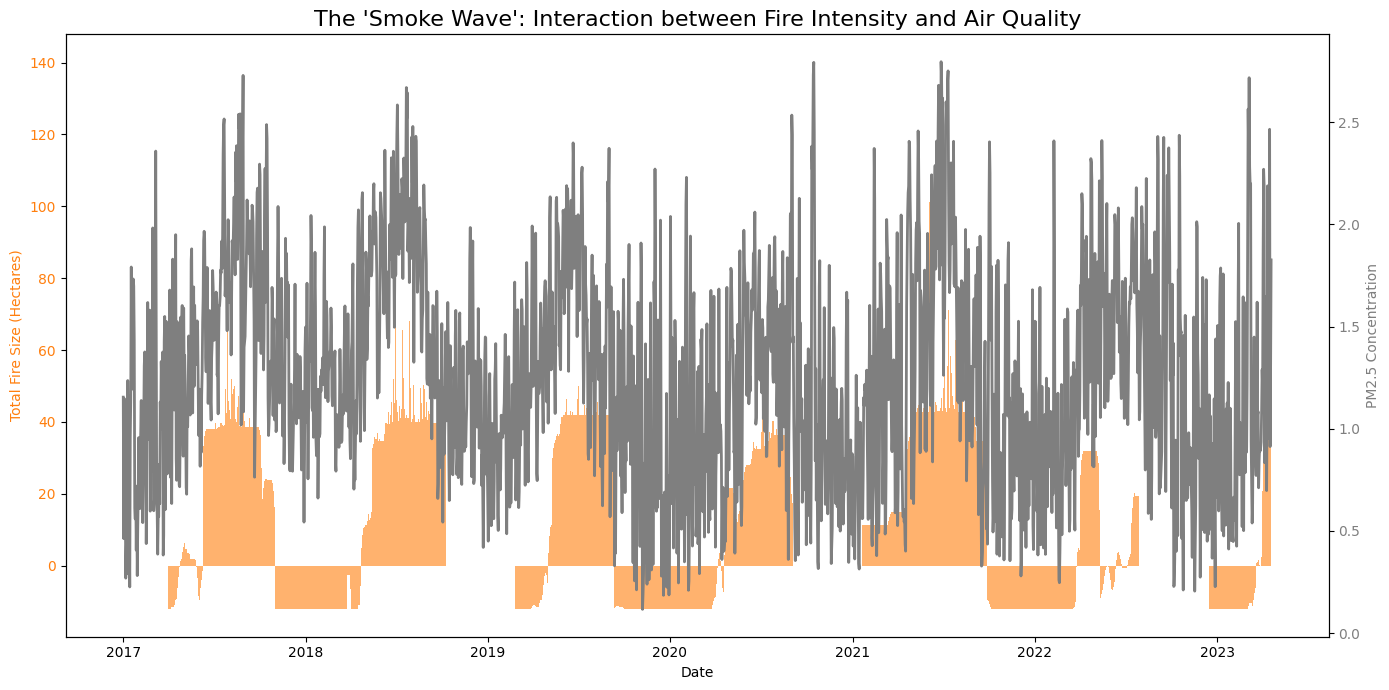

In [89]:
# Aggregating data by Date
daily_data = new_data.groupby('date').agg({
    'PM2.5': 'mean',
    'fire_size_7d_avg': 'sum'}).reset_index()

fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:orange'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Fire Size (Hectares)', color=color)
ax1.bar(daily_data['date'], daily_data['fire_size_7d_avg'], color=color, alpha=0.6, label='Fire Size')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:gray'
ax2.set_ylabel('PM2.5 Concentration', color=color)
ax2.plot(daily_data['date'], daily_data['PM2.5'], color=color, linewidth=2, label='PM2.5')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("The 'Smoke Wave': Interaction between Fire Intensity and Air Quality", fontsize=16)
fig.tight_layout()


The orange area represents Total Fire Size.

The data appears in distinct "blocks," clearly marking the start and end of the wildfire season each year.

During these orange periods, the potential for smoke is high. When the orange area is flat/low (or negative), the fire risk is minimal or non-existent (likely winter).

The grey line represents PM2.5 Concentration.

The grey line becomes much more "jagged" and volatile during the periods where the orange blocks are high (e.g., mid-2018, mid-2021). This suggests that active fires destabilize local air quality, causing rapid spikes.

In the gaps between fire seasons (the white spaces in the orange graph), the grey PM2.5 line is often tighter and less chaotic, though baseline pollution still exists.

<Figure size 640x480 with 0 Axes>

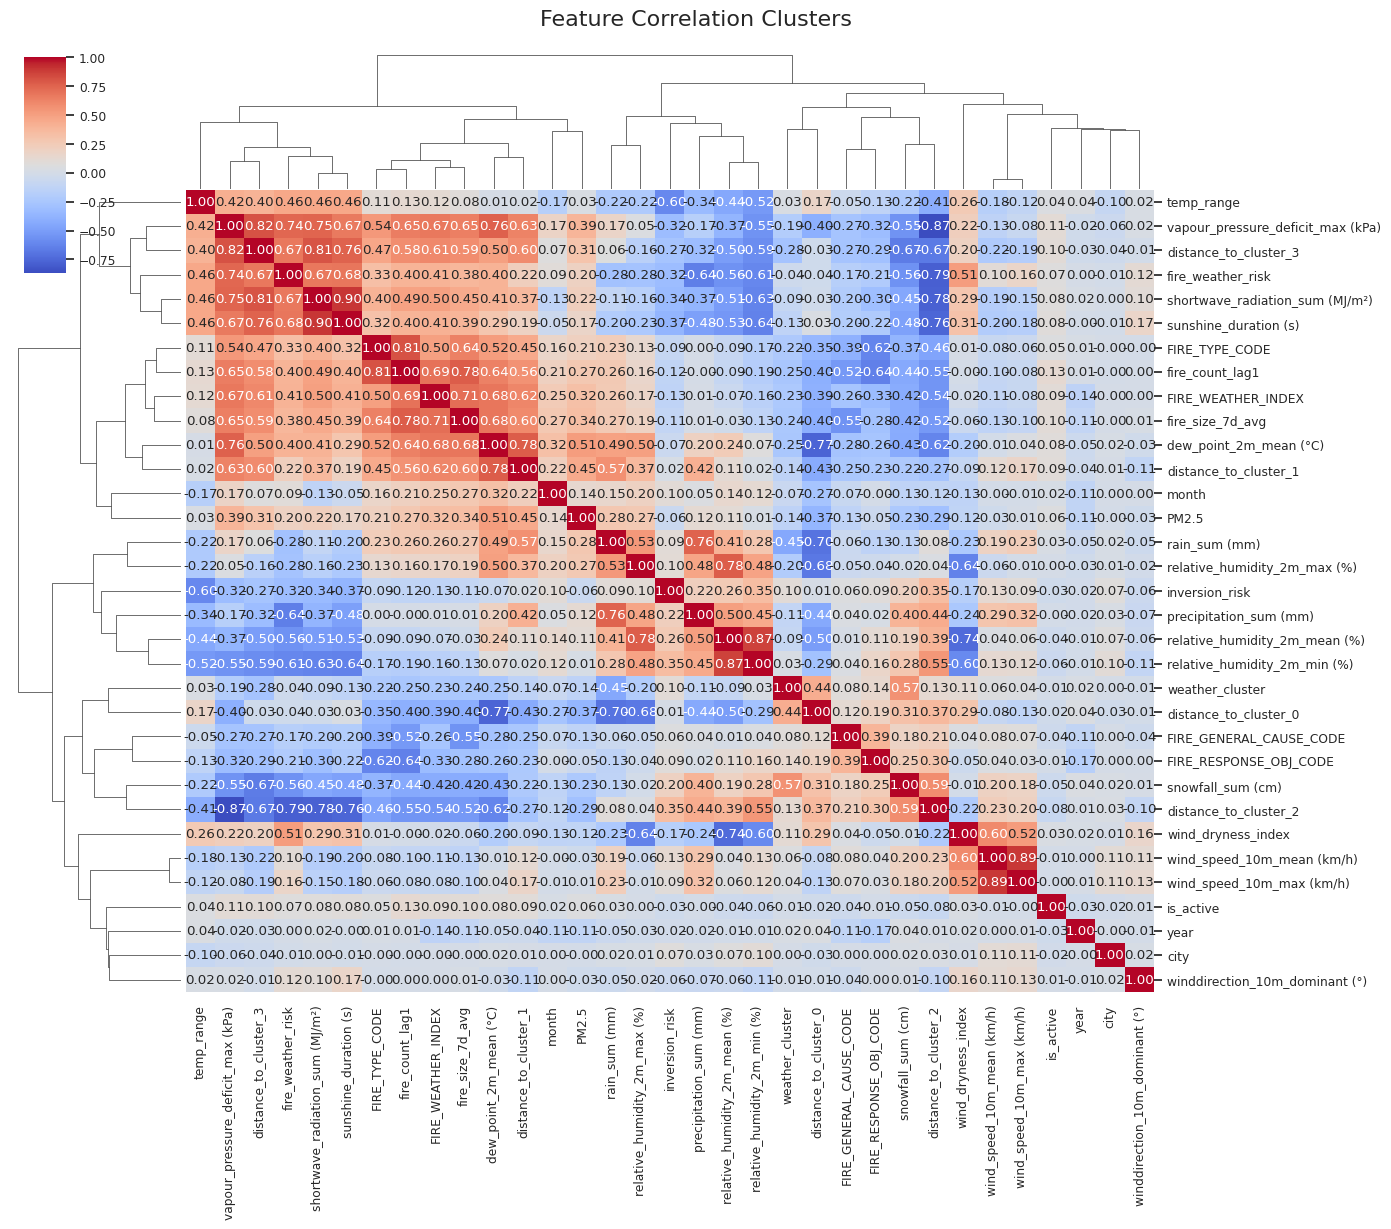

In [94]:
numeric_cols = new_data.select_dtypes(include=['float64', 'int64'])
plt.clf()
sns.set_theme(font_scale=0.8)


g = sns.clustermap(
    numeric_cols.corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    figsize=(14, 12),
    dendrogram_ratio=0.15,
    cbar_pos=(0.02, 0.8, 0.03, 0.18)
)

g.fig.suptitle("Feature Correlation Clusters", y=1.02, fontsize=16)

plt.show()

/tmp/ipython-input-1674441402.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='Year', y='PM2.5', data=new_data, palette="viridis")


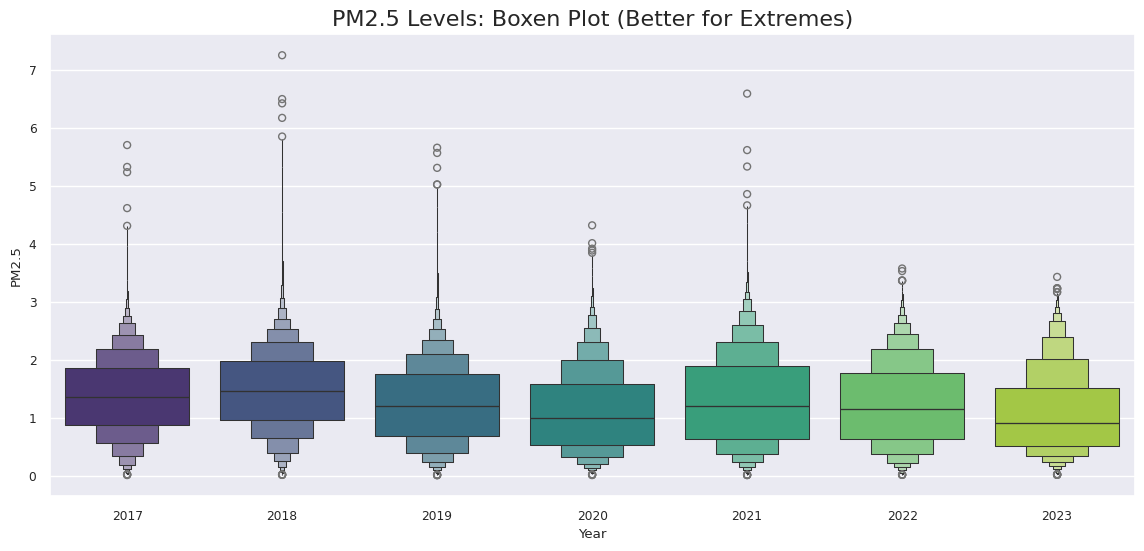

In [107]:
import matplotlib.ticker as ticker

if 'Date' not in new_data.columns:
    new_data['Date'] = pd.to_datetime(new_data['date'])
if 'Year' not in new_data.columns:
    new_data['Year'] = new_data['Date'].dt.year

plt.figure(figsize=(14, 6))
sns.boxenplot(x='Year', y='PM2.5', data=new_data, palette="viridis")
 # Boxen plots handle log scales natively much better
plt.title("PM2.5 Levels: Boxen Plot (Better for Extremes)", fontsize=16)
plt.show()

There is a visible improvement in air quality over the observed period. The median PM2.5 level (represented by the horizontal line across the widest box) shows a general decline from 2017/2018 to 2023.

The year 2018 appears to have been the most volatile. It exhibits the highest median value and significant extreme outliers (reaching values >7.0), indicating frequent spikes in pollution levels.

Extreme Events (Right Skew): For every year, the distribution is heavily right-skewed. The "stacked" boxes extending upward indicate that while the majority of measurements fall within a lower range (0–2), there are consistent sporadic events of high pollution.

By 2023, the distribution has compressed significantly. The median is at its lowest point (below 1.0), and the extreme outliers are much lower compared to previous years (maxing out around 3.5), suggesting a stabilization of air quality control or favorable environmental conditions.

There is a dip in 2020 (potentially related to pandemic-related reduced activity), followed by a slight rebound in median and outliers in 2021, before the trend decreases again in 2022 and 2023.

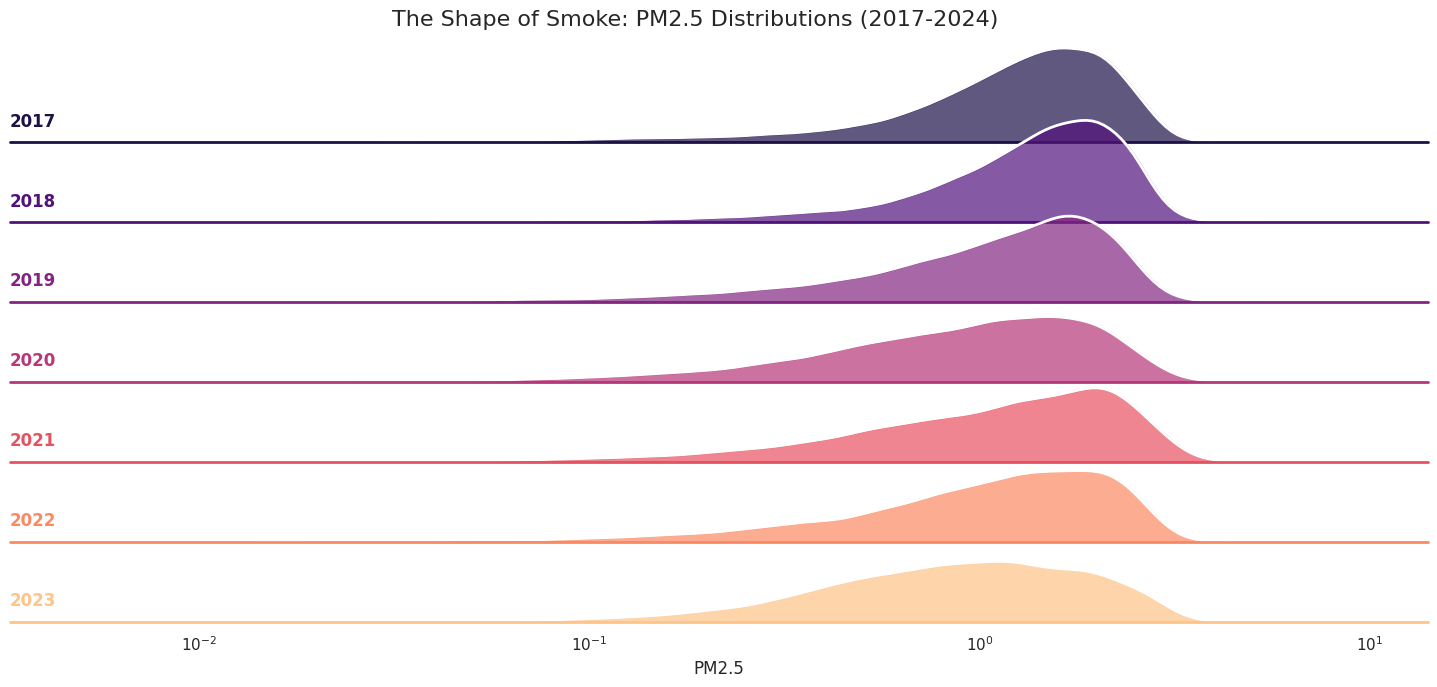

In [109]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
g = sns.FacetGrid(new_data, row="Year", hue="Year", aspect=15, height=1, palette="magma")

g.map(sns.kdeplot, "PM2.5", fill=True, alpha=0.7, linewidth=1.5, log_scale=True)
g.map(sns.kdeplot, "PM2.5", color="white", lw=2, log_scale=True)

g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "PM2.5")

g.figure.subplots_adjust(hspace=-.25)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

plt.suptitle("The Shape of Smoke: PM2.5 Distributions (2017-2024)", y=0.98, fontsize=16)
plt.show()

The Ridge Plot (or Joy Plot) visualizes the distribution density of PM2.5 levels for each year. Unlike the Boxen plot, which focuses on quantiles and outliers, this plot highlights the shape and modal peaks of the data. Note that the X-axis is on a logarithmic scale, allowing us to see details in low-pollution ranges that would otherwise be compressed.

* Leftward Shift (Improvement):There is a clear progression from top to bottom (2017 to 2023). In 2017 and 2018, the main "hump" (the mode, or most common value) is positioned further to the right, indicating higher typical pollution levels. By 2023, this peak has shifted noticeably to the left, centering closer to the $10^{-1}$ to $10^{0}$ range.
* Change in Kurtosis (Peakedness):
  * 2017-2019: The distributions are somewhat sharper on the right side, suggesting that while the baseline was high, the values were clustered tightly around that high baseline.
   * 2022-2023: The curves appear flatter and wider on the left side. This suggests that while we still have high pollution days (the long tails to the right), there is a much higher frequency of "very clean" days pulling the distribution average down.
* The "Heavy Tail" Persistence:Despite the improvement in median levels (the shift of the peak), every year retains a long tail extending to the right ($>10^0$). This confirms that extreme pollution events are a persistent feature of the environment, even as the general "everyday" air quality improves.

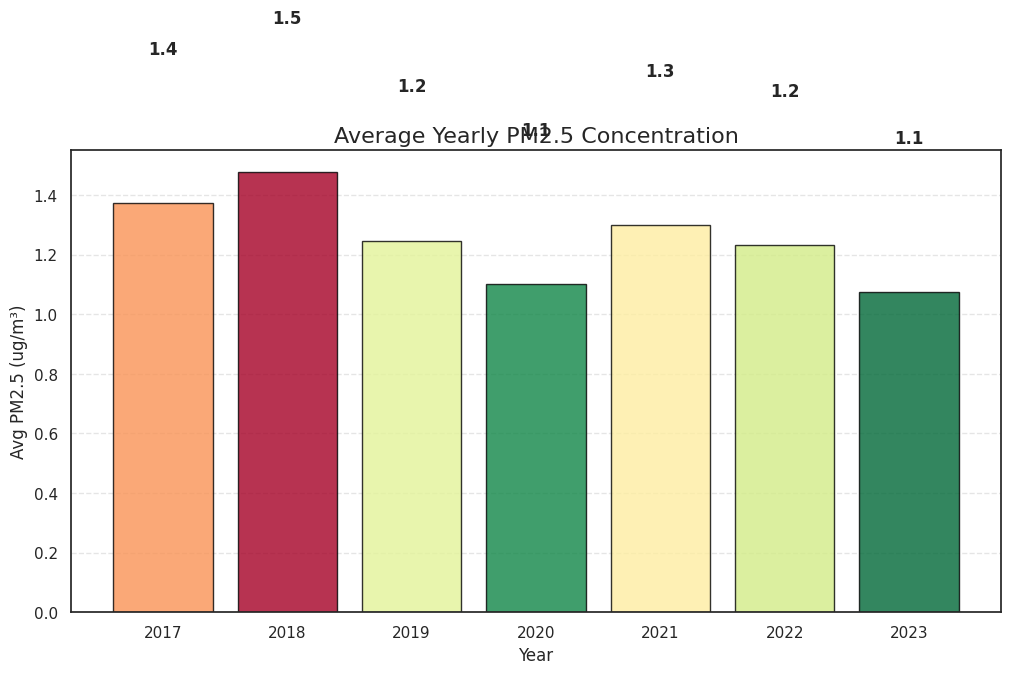

In [111]:
yearly_data = new_data.groupby('Year')['PM2.5'].mean().reset_index()

plt.figure(figsize=(12, 6))


norm = plt.Normalize(yearly_data['PM2.5'].min(), yearly_data['PM2.5'].max())
colors = plt.cm.RdYlGn_r(norm(yearly_data['PM2.5']))

bars = plt.bar(yearly_data['Year'], yearly_data['PM2.5'], color=colors, edgecolor='black', alpha=0.8)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 1), ha='center', fontweight='bold')

plt.title("Average Yearly PM2.5 Concentration", fontsize=16)
plt.ylabel("Avg PM2.5 (ug/m³)")
plt.xlabel("Year")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

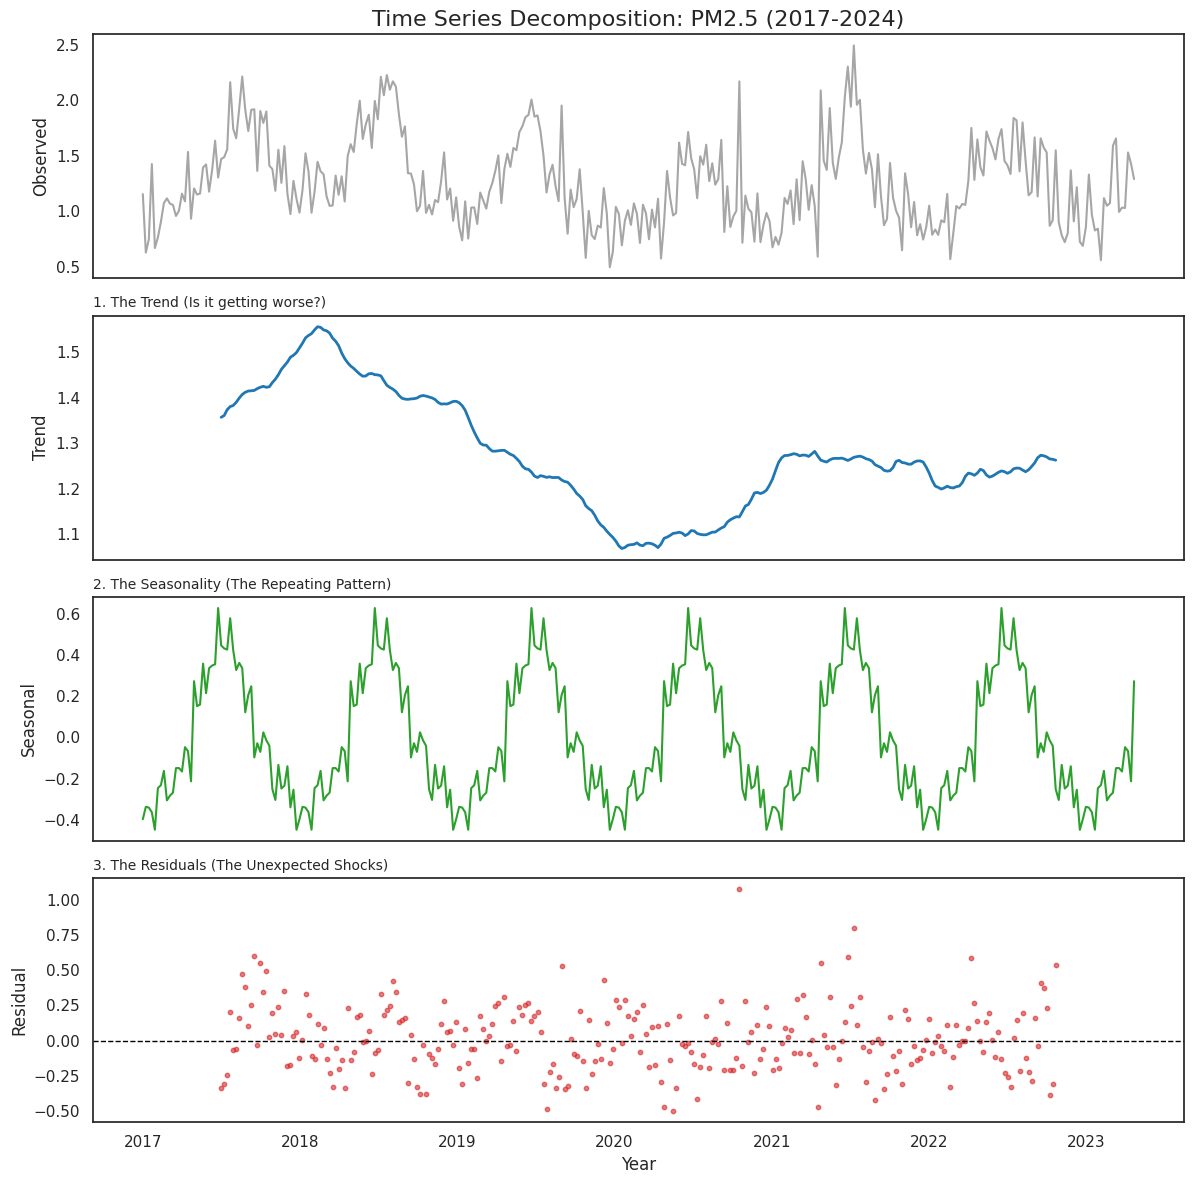

In [115]:
PM25_COL = 'PM2.5'

new_data['Date'] = pd.to_datetime(new_data['date'])
ts_df = new_data.set_index('Date').sort_index()

weekly_pm = ts_df[PM25_COL].resample('W').mean()

weekly_pm = weekly_pm.interpolate(method='linear')


result = seasonal_decompose(weekly_pm, model='additive', period=52)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

ax1.plot(result.observed, label='Cleaned Data', color='gray', alpha=0.7)
ax1.set_ylabel('Observed')
ax1.set_title('Time Series Decomposition: PM2.5 (2017-2024)', fontsize=16)

ax2.plot(result.trend, label='Trend', color='tab:blue', linewidth=2)
ax2.set_ylabel('Trend')
ax2.set_title('1. The Trend (Is it getting worse?)', fontsize=10, loc='left')

ax3.plot(result.seasonal, label='Seasonality', color='tab:green')
ax3.set_ylabel('Seasonal')
ax3.set_title('2. The Seasonality (The Repeating Pattern)', fontsize=10, loc='left')

ax4.scatter(weekly_pm.index, result.resid, label='Residual', color='tab:red', s=10, alpha=0.6)
ax4.axhline(0, color='black', linestyle='--', linewidth=1)
ax4.set_ylabel('Residual')
ax4.set_title('3. The Residuals (The Unexpected Shocks)', fontsize=10, loc='left')

plt.xlabel('Year')
plt.tight_layout()
plt.show()

The Trend (Underlying Movement): Pollution levels show a distinct cycle: rising to a peak in 2018, dropping sharply to a low in 2020, and recently stabilizing (plateauing) rather than continuing to drop.

The Seasonality (Predictable Cycle): The annual pattern is remarkably consistent and high-amplitude. This confirms that time-of-year (likely weather or seasonal heating) is the strongest predictor of PM2.5 levels, regardless of the year.

The Residuals (Anomalies): While mostly random noise, the 2021 data shows significant positive spikes (red dots above 0.75). These represent irregular "shocks"—such as wildfires or specific industrial events—that defied the standard seasonal forecast.